Using:
    https://gist.github.com/EdwardJRoss/86b31848a7951411de56f10f55e9de4e
    https://forums.fast.ai/t/character-level-language-model/31379
    
Lesson 3 RNN

Offline steps:

1. Combine scraped files
2. Use Notepad++ to convert encoding to UTF8
3. sort out carriage returns etc.
4. End up with rawest_just_eat.csv 


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
import string
from unidecode import unidecode


In [3]:
df = pd.read_csv('/home/trpb2/data/takeaway/rawest_just_eat.csv')

In [4]:
df.columns = ['text','label','label2','label3']

In [5]:
df['text'] = df.text.str.lower()

## Get rid of some key chains
we just take their most common tag in each column

In [6]:
hard_coded_chains = ["asda kitchen", "basilico", "bella italia", "birdbox", "blazing bird", "burger king", "caspian pizza", "chicken cottage", "chiquito", "firezza", "frankie & benny's", "gbk", "greggs", "harvester", "itsu", "kfc", "kick ass", "las iguanas", "papa john", "pizza hut", "stack & grill", "stacks", "subway", "tim horton", "toby carvery", "tortilla -", "turtle bay", "wimpy", "yo!"]
for chain in hard_coded_chains:
    to_drop = df[df.text.str.contains(chain, regex= True, na=False)]
    df = df[~df.text.isin(to_drop.text.tolist())]
    to_append = {'text' : chain, 'trim':chain, 'trim2':chain}
    labels = ['label','label2','label3']
    for l in labels:
        mode_l = to_drop[l].mode()
        if len(mode_l) > 0:
            to_append[l] = mode_l[0]
        else:
            to_append[l] = np.nan
    df = df.append(to_append, ignore_index=True)
    
# warning because of brackets in gbk

In [7]:
df['trim'] = df['text'].str.split(r' - ').str.get(0)
df['trim2'] = df['text'].str.split(" \(").str.get(0)

In [8]:
# name_classes1 = df.groupby(df.trim).size().reset_index(name='count')
# name_classes2 = df.groupby(df.trim2).size().reset_index(name='count')

In [9]:
sus_chains = df[(df['trim']!=df['text'])|(df['trim2']!=df['text'])]
print([sus_chains[col].str.len().min() for col in ['trim','trim2']])


[2, 3]


In [10]:
sus_chains = df[(df['trim']!=df['text'])]['trim'].to_list()
sus_chains2 = df[(df['trim2']!=df['text'])]['trim2'].to_list()
sus_chains_list = sus_chains + sus_chains2
len(sus_chains)

892

In [11]:
my_count = Counter(sus_chains_list)
counts = pd.DataFrame(my_count.most_common(), columns=['text', 'count'])

In [12]:
counts[counts['count']>1]

,text,count
0,cornstar taco's,50
1,harry ramsden,50
2,favorite chicken & ribs,36
3,kaspa's,35
4,roosters piri piri,32
5,creams,28
6,the ice cream hub,28
7,wenzel's,27
8,cluxxx it,24
9,dixy chicken,21


In [13]:
# leave at 10 to catch chains not duplicates - need to review by eye
# chain_dupe1 = name_classes1.loc[name_classes1['count']> 10,['trim']].trim.to_list()
# chain_dupe2 = name_classes2.loc[name_classes2['count']> 10,['trim2']].trim2.to_list()
# to_trim_down = list(set().union(chain_dupe1,chain_dupe2))
to_trim_down = counts.loc[counts['count']> 1,['text']].text.to_list()

In [14]:
to_trim_down

["cornstar taco's",
 'harry ramsden',
 'favorite chicken & ribs',
 "kaspa's",
 'roosters piri piri',
 'creams',
 'the ice cream hub',
 "wenzel's",
 'cluxxx it',
 'dixy chicken',
 'pieminister',
 'chopstix noodle bar',
 "big john's",
 'coast to coast',
 'little dessert shop',
 "fish'n'chick'n",
 'the pie guys',
 'tops pizza',
 'wok & go',
 "nando's",
 "pepe's piri piri",
 'giraffe',
 'king of wings',
 "churchill's fish & chips",
 'tikka twins',
 'wrapchic',
 'wrapstar',
 'chop & wok',
 'oodles chinese',
 'hooked',
 "auntie anne's",
 "miss millie's fried chicken",
 'deep blue',
 'sprinkles gelato',
 'bella napoli pizzeria',
 'delightful desserts',
 "ed's easy diner",
 'ultimate cafe',
 'clucks burger',
 "garfunkel's",
 "joe's kitchen",
 'afters',
 "drake's fish & chips",
 'zabardast',
 'the pizza room',
 'burrito kitchen',
 'el taco loco',
 'marco & carl',
 'oriental express',
 'the urban chocolatier',
 'aspendos',
 'tinseltown',
 'fast break',
 'buddies usa',
 'burger plus',
 'the good 

In [15]:
# for chain in chain_dupe1:
#     to_drop = df[df['trim'] == chain]
#     df = df[df['trim'] != chain] 
#     to_append = {'text' : chain, 'trim':chain, 'trim2':chain}
#     labels = ['label','label2','label3']
#     for l in labels:
#         mode_l = to_drop[l].mode()
#         if len(mode_l) > 0:
#             to_append[l] = mode_l[0]
#         else:
#             to_append[l] = np.nan
#     df = df.append(to_append, ignore_index=True)
    

In [16]:
# for chain in chain_dupe2:
#     to_drop = df[df['trim2'] == chain]
#     df = df[df['trim2'] != chain] 
#     to_append = {'text' : chain, 'trim':chain, 'trim2':chain}
#     labels = ['label','label2','label3']
#     for l in labels:
#         mode_l = to_drop[l].mode()
#         if len(mode_l) > 0:
#             to_append[l] = mode_l[0]
#         else:
#             to_append[l] = np.nan
#     df = df.append(to_append, ignore_index=True)

In [17]:
for chain in to_trim_down:
    to_drop = df[df.text.str.contains(chain, regex= True, na=False)]
    df = df[~df.text.isin(to_drop.text.tolist())]
    to_append = {'text' : chain, 'trim':chain, 'trim2':chain}
    labels = ['label','label2','label3']
    for l in labels:
        mode_l = to_drop[l].mode()
        if len(mode_l) > 0:
            to_append[l] = mode_l[0]
        else:
            to_append[l] = np.nan
    df = df.append(to_append, ignore_index=True)
    
# warning because of brackets in gbk

In [18]:
df[df.text.str.contains('zaytun', regex= True, na=False)]

,text,label,label2,label3,trim,trim2
18546,zaytun restaurant,Kurdish,Middle Eastern,Halal,zaytun restaurant,zaytun restaurant
18736,zaytun restaurant,Lebanese,Kurdish,Halal,zaytun restaurant,zaytun restaurant


## Character Set

What letters outside of ASCII are in the names?


In [19]:
df = df.drop(columns=['trim', 'trim2', 'label3'])

In [20]:
foreign_chars = Counter(_ for _ in ''.join(str(list(df.text))) if _ not in string.ascii_letters)
foreign_chars.most_common()


[(' ', 63560),
 ("'", 47844),
 (',', 25046),
 ('"', 4656),
 ('&', 2329),
 ('-', 386),
 ('?', 262),
 ('2', 219),
 ('.', 204),
 ('1', 199),
 ('@', 177),
 ('(', 139),
 (')', 139),
 ('4', 118),
 ('0', 97),
 ('3', 78),
 ('8', 75),
 ('9', 55),
 ('7', 52),
 ('5', 51),
 ('6', 49),
 ('‚', 28),
 ('!', 23),
 ('`', 22),
 ('ď', 19),
 ('/', 11),
 ('\\', 7),
 ('+', 7),
 ('#', 6),
 ('ř', 3),
 ('*', 3),
 ('˘', 2),
 ('š', 2),
 ('”', 2),
 (':', 2),
 ('%', 2),
 ('[', 1),
 ('©', 1),
 ('~', 1),
 ('„', 1),
 (']', 1)]

In [21]:
df['ascii_name'] = df.text.apply(lambda x: unidecode(str(x)))
df[df.text != df.ascii_name]

,text,label,label2,ascii_name
35,afromumii @ lovelygloworm caf‚,African,Caribbean,"afromumii @ lovelygloworm caf,"
312,hot ďnď tender l1,American,Italian,hot dnd tender l1
599,romulo caf‚,Asian,Filipino,"romulo caf,"
629,caf‚ bagel,Bagels,Vegan,"caf, bagel"
831,caf‚ aroma,Breakfast,Burgers,"caf, aroma"
837,caf‚ cross the mersey,Breakfast,Roast Dinners,"caf, cross the mersey"
873,city caf‚,Breakfast,British,"city caf,"
910,deli de mam,Breakfast,Burgers,deli de mam
1120,paula's caf‚,Breakfast,Caf‚,"paula's caf,"
1145,rose's caf‚,Breakfast,Burgers,"rose's caf,"


In [22]:
foreign_chars = Counter(_ for _ in ''.join(str(list(df.ascii_name))) if _ not in string.ascii_letters)
foreign_chars.most_common()

[(' ', 63561),
 ("'", 47844),
 (',', 25076),
 ('"', 4658),
 ('&', 2329),
 ('-', 386),
 ('?', 262),
 ('2', 219),
 ('.', 204),
 ('1', 198),
 ('@', 177),
 ('(', 140),
 (')', 140),
 ('4', 118),
 ('0', 96),
 ('3', 78),
 ('8', 66),
 ('9', 55),
 ('7', 52),
 ('5', 51),
 ('6', 49),
 ('!', 23),
 ('`', 22),
 ('/', 11),
 ('+', 7),
 ('#', 6),
 ('*', 3),
 (':', 2),
 ('%', 2),
 ('[', 1),
 ('~', 1),
 ('\\', 1),
 (']', 1)]

In [23]:
df['ascii_name_fix'] = df.ascii_name.str.replace('`',"'")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('~'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace(']'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('['," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('\\'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('%'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('*'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace(':'," ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('+'," and ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('&'," and ")
df['ascii_name_fix'] = df.ascii_name_fix.str.replace('/'," ")
suss_chars = ['`',']','%','&']
df[df.ascii_name_fix.str.contains('|'.join(suss_chars))]

,text,label,label2,ascii_name,ascii_name_fix


In [24]:
df = df.drop(columns=['text', 'ascii_name'])

## Check for duplicates


These are remaining duplicates with different classes

In [25]:
name_classes = df.\
  groupby('ascii_name_fix').size().reset_index(name='counts')

Use similar logic to removing chains to take the most popular labels

In [26]:
to_dedupe = name_classes[name_classes['counts'] > 1]['ascii_name_fix'].to_list()

In [27]:
to_dedupe

['1st class pizza',
 '2-4-1 pizza',
 '241 pizza',
 '3 for 10 pizza',
 '500 degrees pizzeria',
 '7 spices',
 '900r degrees',
 'a mano',
 'a taste of india',
 'a touch of spice',
 "a'la pizza  and  grill",
 'abbey fish bar',
 'abduls',
 'aburi japanese restaurant',
 'acropolis',
 "adam's pizza",
 "adam's pizzeria",
 'adams',
 'afc',
 'agra',
 'akash',
 'akash restaurant',
 'akash tandoori',
 'akash tandoori restaurant',
 'amaretto ristorante pizzeria',
 'american fried chicken',
 'american grill peri peri',
 'american pizza',
 'american pizza house',
 'american slice',
 'amigo',
 'amigo pizza',
 "amigo's",
 'amigos',
 'amigos pizza',
 'amore pizza',
 'amran tandoori',
 "angelo's fish bar",
 'anglo pizza',
 'anise',
 'antep pizza',
 'antonios pizza',
 'apna lahore',
 'ariana restaurant',
 'aroma',
 'aroma indian takeaway',
 'aroma kitchen',
 'aroma lounge',
 'aroma pizza',
 'aroma spice',
 'asha',
 'ashiana',
 'ashoka',
 'asia villa',
 'asian tandoori',
 'asiana',
 'athena',
 'atlantic fi

In [28]:
for chain in to_dedupe:
    to_drop = df[df['ascii_name_fix'] == chain]
    df = df[df['ascii_name_fix'] != chain]
    to_append = {'ascii_name_fix' : chain}
    labels = ['label','label2']
    for l in labels:
        mode_l = to_drop[l].mode()
        if len(mode_l) > 0:
            to_append[l] = mode_l[0]
        else:
            to_append[l] = np.nan
    df = df.append(to_append, ignore_index=True)

In [29]:
df[['label','label2']] = df[['label','label2']].astype(str)

check for duplicate name label combinations

In [30]:
counts = df.assign(n=1).groupby(['ascii_name_fix', 'label', 'label2']).count().sort_values('n', ascending=False)
counts.tail(n=20)

,,,n
ascii_name_fix,label,label2,
grimsby tandoori,Indian,Curry,1
grind ?n? bake,Caf‚,Cakes,1
grinders of london,Sandwiches,Desserts,1
grindon tandoori,Indian,Curry,1
guan can cook,Chinese,Oriental,1
gt hot point caribbean take away,Caribbean,Halal,1
grubz,Caribbean,British,1
grub and liquor,Burgers,nan,1
gru shisha lounge and restaurant,Lebanese,Burgers,1



### Distribution by Cuisine

The dataset is very unbalanced.


In [31]:
label_count = df.groupby('label').ascii_name_fix.count().sort_values(ascending=False)

In [32]:
label_count[20:70]

label
Curry               147
British             127
Sandwiches          123
Sushi               106
Mediterranean       105
African             105
English             103
Greek                97
Healthy              82
Vegan                76
Persian              53
Asian                51
Bangladeshi          47
Vietnamese           47
Nepalese             46
Jamaican             43
Middle Eastern       42
Fast Food            42
Pakistani            41
Steak                33
Ice Cream            31
Pasta                30
Deli                 28
European             27
Bubble Tea           27
Korean               26
Cakes                26
Afghan               26
Spanish              25
BBQ                  24
Gourmet              23
Noodles              21
Vegetarian           21
Milkshakes           20
South Indian         19
French               18
Arabic               18
Lunch                17
Bagels               16
Polish               16
Portuguese           15
Sri-lankan

In [33]:
df.groupby('label2').ascii_name_fix.count().sort_values(ascending=False)

label2
Curry              2642
Pizza              2628
Kebab              2202
Oriental           1408
Burgers            1208
nan                 719
Italian             651
Chicken             635
Grill               469
Bangladeshi         427
Indian              361
American            339
Desserts            323
Fish & Chips        305
Breakfast           301
British             255
Thai                244
English             244
Peri Peri           235
Mediterranean       221
Sandwiches          194
Ice Cream           193
Noodles             188
Halal               188
Asian               172
Chinese             163
Fast Food           163
Japanese            161
Milkshakes          144
Jamaican            141
                   ... 
Soup                  3
Scottish              2
Baguettes             2
Egyptian              2
Ethiopian             2
Pies                  2
West African          2
North African         2
Argentinian           2
Tex-Mex               1
Ukrainian

In [34]:
df2 = pd.DataFrame(np.sort(df[['label', 'label2']], axis=1), index=df.index)
df2.columns = ['label', 'label2']
combos = df2.groupby(['label', 'label2']).size().reset_index(name='counts')

In [35]:
combos_10 = combos[combos['counts']>10]
combos[combos['label']=='Fast Food'],combos[combos['label2']=='Fast Food']

(         label        label2  counts
 705  Fast Food  Fish & Chips      12
 706  Fast Food        French       1
 707  Fast Food       Gourmet       1
 708  Fast Food         Grill       7
 709  Fast Food       Healthy       2
 710  Fast Food      Hot Dogs       1
 711  Fast Food        Indian      17
 712  Fast Food       Italian       1
 713  Fast Food      Jamaican       1
 714  Fast Food         Kebab      19
 715  Fast Food         Lunch       2
 716  Fast Food       Mexican       3
 717  Fast Food    Milkshakes       1
 718  Fast Food     Pakistani       1
 719  Fast Food     Peri Peri       3
 720  Fast Food         Pizza      50
 721  Fast Food    Sandwiches       1
 722  Fast Food         Vegan       2
 723  Fast Food           nan       3,          label     label2  counts
 24     African  Fast Food       1
 61    American  Fast Food       7
 260    British  Fast Food       4
 322    Burgers  Fast Food      15
 377       Caf‚  Fast Food       1
 421  Caribbean  Fast Food    

## Crafting the mappings

Here we generate the mappings

In [36]:
dead_certain = {'Curry':'Indian', 'Bangladeshi':'Indian', 'Nepalese':'Indian', 'Pakistani':'Indian', 'South Indian':'Indian', 'Sri Lankan':'Indian',
                'Ice Cream':'Desserts', 'Cakes':'Desserts', 'Milkshakes':'Desserts', 'Crepes':'Desserts', 'Waffles':'Desserts',
                'Italian':'Pizza', 'Italian Pizza':'Pizza',
                'Noodles':'Chinese', 'Oriental':'Chinese', 'Cantonese':'Chinese', 'Dim Sum':'Chinese',

                #'Turkish':'MedMid', 'Lebanese':'MedMid', 'Mediterranean':'MedMid', 'Greek':'MedMid', 'Middle Eastern':'MedMid', 'Persian':'MedMid', 'Afghan':'MedMid',
                #'African':'AfroCarib','Caribbean':'AfroCarib', 'Jamaican':'AfroCarib', 'Nigerian':'AfroCarib',
                'Gourmet Burgers':'Burgers',
                'Caf‚':'Sand/Caf/Bake', 'Sandwiches':'Sand/Caf/Bake', 'Wraps':'Sand/Caf/Bake', 'Bagels':'Sand/Caf/Bake', "Panini's":'Sand/Caf/Bake',
 }

key_list = ['Indian', 'Chinese', 'Fish & Chips']

yuck = ['Peri Peri', 'American', 'Breakfast', 'British', 'Grill', 'Turkish', 'Lebanese', 'English', 'African',
       'Caribbean', 'Jamaican', 'Mexican','Sushi', 'Japanese', 'Mediterranean', 'Greek', 'Persian', 'Middle Eastern',
       'Thai','Vietnamese']

In [37]:
df2 = df.replace({"label": dead_certain})
df3 = df2.replace({"label2": dead_certain})

In [38]:
label_count = df3.groupby('label').ascii_name_fix.count().sort_values(ascending=False)

In [39]:
label_count2 = df3.groupby('label2').ascii_name_fix.count().sort_values(ascending=False)

In [291]:
df4 = pd.DataFrame(np.sort(df3[['label', 'label2']], axis=1), index=df.index)
df4.columns = ['label', 'label2']
combos = df4.groupby(['label', 'label2']).size().reset_index(name='counts')

In [292]:
combos[combos['label']=='Fast Food'],combos[combos['label2']=='Fast Food']

(         label         label2  counts
 543  Fast Food   Fish & Chips      12
 544  Fast Food         French       1
 545  Fast Food        Gourmet       1
 546  Fast Food          Grill       7
 547  Fast Food        Healthy       2
 548  Fast Food       Hot Dogs       1
 549  Fast Food         Indian      24
 550  Fast Food       Jamaican       1
 551  Fast Food          Kebab      19
 552  Fast Food          Lunch       2
 553  Fast Food        Mexican       3
 554  Fast Food      Peri Peri       3
 555  Fast Food          Pizza      51
 556  Fast Food  Sand/Caf/Bake       2
 557  Fast Food          Vegan       2
 558  Fast Food            nan       3,          label     label2  counts
 20     African  Fast Food       1
 54    American  Fast Food       7
 213    British  Fast Food       4
 268    Burgers  Fast Food      15
 314  Caribbean  Fast Food       6
 347    Chicken  Fast Food      30
 386    Chinese  Fast Food       1
 441   Desserts  Fast Food       6
 501    English  Fast 

In [293]:
label_count[:15],label_count2[:15]

(label
 Indian           4449
 Pizza            3695
 Chinese          2217
 Fish & Chips     1407
 Kebab            1232
 Chicken           853
 Desserts          720
 Burgers           623
 Breakfast         560
 Caribbean         359
 American          350
 Turkish           320
 Thai              303
 Sand/Caf/Bake     298
 Peri Peri         247
 Name: ascii_name_fix, dtype: int64, label2
 Indian           3582
 Pizza            3290
 Kebab            2202
 Chinese          1805
 Burgers          1224
 Desserts          829
 nan               719
 Chicken           635
 Grill             469
 Sand/Caf/Bake     383
 American          339
 Fish & Chips      305
 Breakfast         301
 British           255
 Thai              244
 Name: ascii_name_fix, dtype: int64)

Optionally add the the Fast Food tag with outlets selling more than 2 of pizza, kebab, chicken, burger, fast food

In [294]:
fast_foods = ['Fast Food', 'Pizza', 'Burger', 'Kebab', 'Chicken']

In [295]:
#df3['label_final'] = np.where((df3['label'].isin(fast_foods)) | (df3['label2'].isin(fast_foods)), 'Fast Food', 'no')
#option for fast food category separately
df3['label_final'] = np.where((df3['label'].isin(fast_foods)) & (df3['label2'].isin(fast_foods)) & (df3['label'] != df3['label2']), 'Fast Food', 'no')
#df3['label_final'] = 'no'

In [296]:
df3

,label,label2,ascii_name_fix,label_final
0,Afghan,Grill,ababeel,no
1,Afghan,Kebab,afghan chopan restaurant,no
2,Afghan,Halal,afghan spice takeaway,no
3,Afghan,Indian,amran grill and pizza,no
4,Afghan,Greek,ariana flame grill,no
5,Afghan,Persian,ariana ii - kilburn,no
6,Afghan,Indian,bismillah restaurant,no
7,Afghan,Indian,charsi karahi,no
8,Afghan,Persian,chop and dooz,no
9,Afghan,nan,chopan,no


In [297]:
#my_cuisines =  ['AfroCarib', 'Chinese', 'Indian', 'Fish & Chips', 'Desserts', 'MedMid', 'Sand/Caf/Bake']
#my_cuisines =  ['Pizza', 'Burgers', 'Kebab', 'Chicken', 'Chinese', 'Indian', 'Fish & Chips', 'Desserts', 'MedMid']
#my_cuisines =  ['Chinese', 'Indian', 'Fish & Chips', 'Desserts', 'Fast Food']
#my_cuisines =  ['Pizza', 'Burgers', 'Kebab', 'Chicken', 'Chinese', 'Indian', 'Fish & Chips', 'Desserts']
my_cuisines =  ['Pizza', 'Burgers', 'Kebab', 'Chicken', 'Chinese', 'Indian', 'Fish & Chips', 'Desserts', 'Fast Food']
df3['label_final'] = np.where((df3['label2'].isin(my_cuisines)), df3['label2'], df3['label_final'])
df3['label_final'] = np.where((df3['label'].isin(my_cuisines)), df3['label'], df3['label_final'])

In [298]:
#if having fast food and component categories
df3['label_final'] = np.where((df3['label'].isin(fast_foods)) & (df3['label2'].isin(fast_foods)) & (df3['label'] != df3['label2']), 'Fast Food', df3['label_final'])

In [299]:
df3 = df3[df3['label_final']!='no']


## Create Validation and Training Sets

We want our final model to work well on any language.

But if we pick our validation set uniformly at random from the data we're likely to get many Indian and not many African, which isn't a good test of this.

So instead we'll take our validation set from an equal number from each subclass.


In [300]:
df3 = df3.reset_index().drop('index', 1)

In [301]:
counts = df3.groupby('label_final').ascii_name_fix.count().sort_values(ascending=False)
counts

label_final
Indian          4583
Pizza           2658
Fast Food       2562
Chinese         2456
Fish & Chips    1447
Burgers          981
Desserts         864
Kebab            803
Chicken          718
Name: ascii_name_fix, dtype: int64

In [302]:
valid_size = 350 # We'll pick 30 at random from each subclass
train_size = 5000 # For a balanced training set we'll pick 500 at random with replacement

In [303]:
np.random.seed(6011)
valid_idx = []
for label in counts.keys():
    # Random sample of size "valid_size" for each class
    valid_idx += list(df3[df3.label_final == label].sample(valid_size).index)

In [304]:
df3['valid'] = False
df3.loc[valid_idx, 'valid'] = True

In [305]:
np.random.seed(7012)
balanced_idx = []
for label in counts.keys():
    # Random sample of size "train_size" for each class from the data outside of the validation set
    balanced_idx += list(df3[(df3.label_final == label) & ~df3.valid].sample(train_size, replace=True).index)

In [306]:
#aims to maximise training data by oversampling smaller classes

np.random.seed(7012)
balanced_idx = []
for label in counts.keys():
    # Random sample of size "train_size" for each class from the data outside of the validation set
    balanced_idx += list(df3[(df3.label_final == label) & ~df3.valid].sample(counts[label]-valid_size).index)
    if counts[label] < train_size:
        balanced_idx += list(df3[(df3.label_final == label) & ~df3.valid].sample(train_size -(counts[label]-valid_size), replace=True).index)

In [307]:
df3.loc[balanced_idx].groupby('label_final').nunique().sort_values('ascii_name_fix', ascending=False)

,label,label2,ascii_name_fix,label_final,valid
label_final,,,,,
Indian,24,53,4233,1,1
Pizza,32,52,2308,1,1
Fast Food,16,17,2212,1,1
Chinese,16,38,2106,1,1
Fish & Chips,10,31,1097,1,1
Burgers,25,39,631,1,1
Desserts,26,31,514,1,1
Kebab,18,25,453,1,1
Chicken,20,29,368,1,1


Let's record our balanced set in the dataframe: this will make it easy to reload at a later point.

In [308]:
df3['bal'] = 0
for k, v in Counter(balanced_idx).items():
    df3.loc[k, 'bal'] += v

In [309]:
df3.to_csv('06_01_2020_sep_f_food_bal.csv', index=False)

## Build a Fastai Data Loader

Load in the dataframe and extract indexes for training, validation and balanced trainings.

In [310]:
df = pd.read_csv('06_01_2020_sep_f_food_bal.csv')

valid_idx = df[df.valid].index
train_idx = df[~df.valid].index

bal_idx = []
for k, v in zip(df.index, df.bal):
    bal_idx += [k]*v



In [311]:
class LetterTokenizer(BaseTokenizer):
    "Character level tokenizer function."
    def __init__(self, lang): pass
    def tokenizer(self, t:str) -> List[str]:
        out = []
        i = 0
        while i < len(t):
            if t[i:].startswith(BOS):
                out.append(BOS)
                i += len(BOS)
            else:
                out.append(t[i])
                i += 1
        return out
            
    def add_special_cases(self, toks:Collection[str]): pass

In [312]:
itos = [UNK, BOS] + list(string.ascii_lowercase + " -'@&)(." +"0123456789")

In [313]:
vocab=Vocab(itos)
tokenizer=Tokenizer(LetterTokenizer, pre_rules=[], post_rules=[])

In [314]:
train_df = df.iloc[train_idx, [3,2]]
bal_df = df.iloc[bal_idx, [3,2]]
valid_df = df.iloc[valid_idx, [3,2]]

In [315]:
valid_df

,label_final,ascii_name_fix
0,Kebab,afghan chopan restaurant
4,Indian,fatboy's joint
8,Kebab,kobeda king
9,Kebab,masa restaurant harrow
17,Chicken,junction1ten
23,Fish & Chips,5 star fish bar
25,Burgers,abm happy kitchen
26,Burgers,adam's diner
40,Burgers,benz burger
46,Kebab,blue point


## Language model

Language model with Just Eat data only

In [316]:
data = TextClasDataBunch.from_df(path='.', train_df=bal_df, valid_df=valid_df,
                         tokenizer=tokenizer, vocab=vocab,
                         mark_fields=False, bs=128)

In [332]:
learn = text_classifier_learner(data, AWD_LSTM,drop_mult=1.0)

In [333]:
learn.load_encoder('just_eat_enc_bs128_2')

In [334]:
learn.freeze()

In [335]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


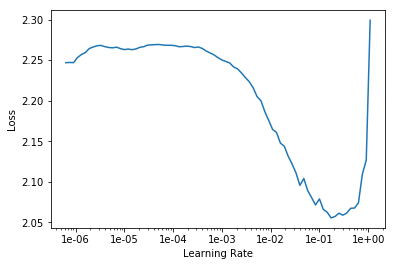

In [336]:
learn.recorder.plot()

In [337]:
lr = 1e-2
moms = (0.1,0.2)
scale = (1**4)
cycles = 5

In [338]:
learn.fit_one_cycle(cycles, lr, moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,1.584924,1.339459,0.552063,00:10
1,1.531934,1.311374,0.561905,00:10
2,1.529189,1.259591,0.579683,00:09
3,1.429793,1.245201,0.595556,00:10
4,1.407318,1.247795,0.594286,00:10


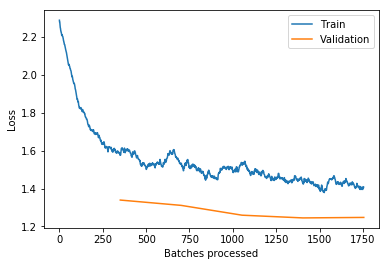

In [339]:
learn.recorder.plot_losses()

In [340]:
learn.freeze_to(-2)

In [341]:
learn.fit_one_cycle(cycles, slice((lr/2)/scale,(lr/2)), moms=moms)
#learn.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.2,0.1))

epoch,train_loss,valid_loss,accuracy,time
0,1.302489,1.210643,0.608889,00:11
1,1.147067,1.205897,0.625079,00:11
2,1.043286,1.198088,0.634921,00:12
3,0.959284,1.212335,0.638730,00:11
4,0.937127,1.237250,0.638095,00:11


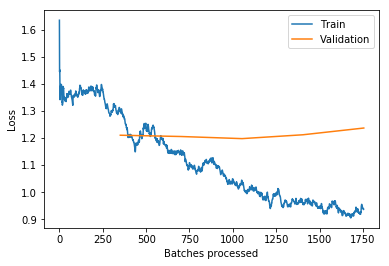

In [342]:
learn.recorder.plot_losses()

In [343]:
learn.freeze_to(-3)
#learn.fit_one_cycle(5, slice(1e-4 / (2.6 ** 4), 1e-4), moms=(0.2, 0.1))
learn.fit_one_cycle(cycles, slice((lr/10)/scale,(lr/10)), moms=moms)

epoch,train_loss,valid_loss,accuracy,time
0,0.895113,1.222485,0.637778,00:17
1,0.889085,1.226429,0.636825,00:18
2,0.881259,1.236015,0.634286,00:20
3,0.881231,1.257907,0.636190,00:17
4,0.855727,1.272891,0.634286,00:18


In [344]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(5e-5 / (2.6 ** 4), 5e-5), moms=(0.2, 0.1))

epoch,train_loss,valid_loss,accuracy,time
0,0.848851,1.261662,0.635556,00:23
1,0.841181,1.247765,0.634603,00:23
2,0.827407,1.245666,0.636190,00:25
3,0.847369,1.264600,0.634603,00:22
4,0.864033,1.258715,0.632698,00:22


In [25]:
    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`"
        x=torch.arange(0,data.c)
        cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        return cm.cpu().numpy()

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", figsize:tuple=None):
        "Plot the confusion matrix"
        # This function is copied from the scikit docs
        cm = self.confusion_matrix()
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, self.data.classes, rotation=45)
        plt.yticks(tick_marks, self.data.classes)

        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [349]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

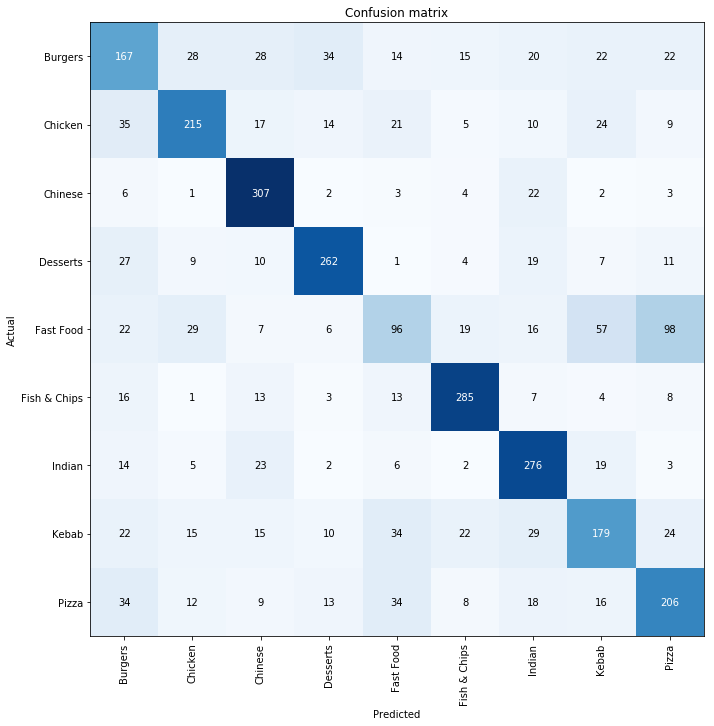

In [350]:
interp.plot_confusion_matrix(figsize=(10,10))

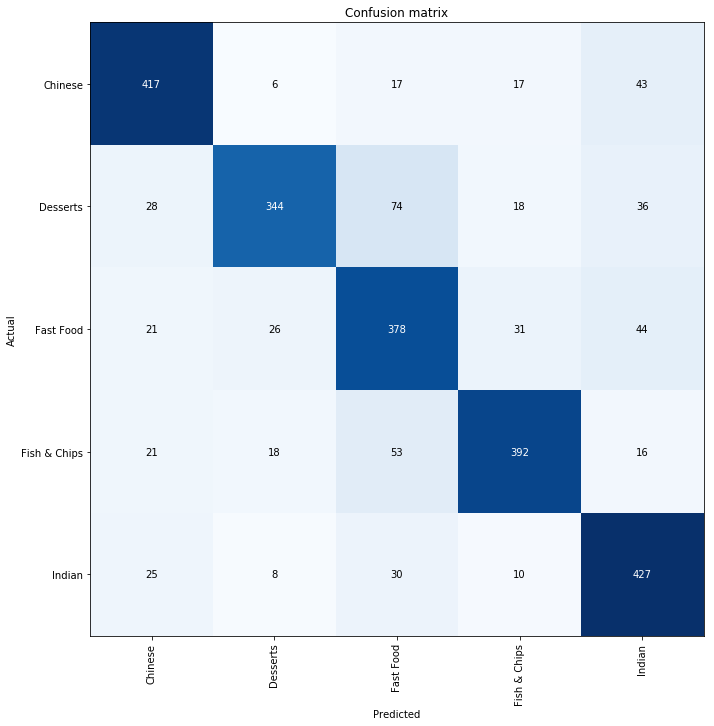

In [27]:
interp.plot_confusion_matrix(figsize=(10,10))

In [220]:
learn.predict("mamoods mirch")

(Category Desserts,
 tensor(3),
 tensor([0.1796, 0.1077, 0.0432, 0.3716, 0.0753, 0.0452, 0.0204, 0.1571]))

In [221]:
learn.predict("fryer tuck")

(Category Fish & Chips,
 tensor(4),
 tensor([1.9349e-04, 2.2762e-04, 3.9516e-04, 7.4763e-06, 9.6288e-01, 1.3179e-03,
         3.1593e-02, 3.3845e-03]))

In [222]:
learn.predict("jade palace")

(Category Chinese,
 tensor(2),
 tensor([0.0089, 0.0007, 0.5523, 0.0466, 0.0684, 0.2753, 0.0038, 0.0441]))

In [223]:
learn.predict("jerk house")

(Category Kebab,
 tensor(6),
 tensor([0.1261, 0.1316, 0.0712, 0.0067, 0.0340, 0.0187, 0.4880, 0.1237]))

In [224]:
learn.predict("abra kebabra")

(Category Kebab,
 tensor(6),
 tensor([2.5068e-04, 3.7197e-04, 2.4338e-05, 1.9032e-05, 9.3639e-05, 6.3625e-02,
         9.2301e-01, 1.2609e-02]))

In [225]:
learn.predict("mcdoner")

(Category Kebab,
 tensor(6),
 tensor([3.7451e-03, 7.3501e-04, 2.7417e-03, 9.5083e-04, 9.6527e-03, 3.6301e-03,
         9.4654e-01, 3.2000e-02]))

In [226]:
learn.predict("southern fried rooster")

(Category Chicken,
 tensor(1),
 tensor([1.2616e-02, 8.9029e-01, 1.7672e-03, 9.7951e-04, 4.8275e-02, 7.6762e-04,
         2.1099e-02, 2.4203e-02]))

In [227]:
learn.predict("luigis pizza parlour")

(Category Pizza,
 tensor(7),
 tensor([1.3365e-03, 7.9343e-04, 6.5138e-04, 3.3532e-04, 8.2864e-03, 1.7876e-03,
         1.3640e-02, 9.7317e-01]))

In [228]:
learn.predict("mrs boggins sandwich shop")

(Category Burgers,
 tensor(0),
 tensor([9.7911e-01, 2.1068e-04, 6.8048e-04, 1.7586e-02, 6.1052e-04, 8.3821e-05,
         4.9676e-04, 1.2234e-03]))

In [229]:
learn.predict("codfather")

(Category Fish & Chips,
 tensor(4),
 tensor([1.0596e-04, 1.6185e-05, 1.7635e-04, 4.8159e-06, 9.7529e-01, 4.7009e-04,
         4.9466e-03, 1.8995e-02]))

In [230]:
learn.predict("top chef")

(Category Chinese,
 tensor(2),
 tensor([0.0019, 0.0042, 0.6980, 0.0023, 0.0632, 0.0519, 0.0515, 0.1270]))

In [231]:
learn.predict("doner cha want me")

(Category Chinese,
 tensor(2),
 tensor([0.0567, 0.0104, 0.3733, 0.0097, 0.0339, 0.1329, 0.2209, 0.1622]))

In [232]:
learn.predict("kebabs r us")

(Category Kebab,
 tensor(6),
 tensor([1.4627e-03, 5.0970e-05, 7.2114e-05, 1.1042e-05, 2.5023e-03, 3.2104e-03,
         9.7965e-01, 1.3037e-02]))

In [233]:
learn.predict("sapna")

(Category Indian,
 tensor(5),
 tensor([0.0462, 0.0026, 0.0909, 0.0027, 0.0320, 0.5112, 0.0784, 0.2359]))

In [234]:
learn.predict("cocum")

(Category Burgers,
 tensor(0),
 tensor([0.4134, 0.0308, 0.0573, 0.0077, 0.1127, 0.1494, 0.1259, 0.1028]))

In [347]:
learn.predict("chickyummy")

(Category Chicken,
 tensor(1),
 tensor([1.6502e-02, 6.5115e-01, 5.5255e-04, 4.1913e-04, 3.1354e-01, 3.0951e-03,
         6.9187e-04, 6.6047e-03, 7.4472e-03]))